In [2]:
import os
import itertools
import glob
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker
import matplotlib.pyplot as plt


sns.set(font_scale=0.9, style='whitegrid', font='CMU Sans Serif')
pal = sns.color_palette(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
sns.set_palette(pal)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,2)
mpl.rcParams['figure.dpi'] = 100

In [3]:
# put current date and time in filename
INPUT_GLOB = "out/gst-sensor*"
INPUT_ORCHESTRATOR = "out/gst-orchestrator.out"

# get date of newest file in output directory
newest_t = datetime.datetime.fromtimestamp(os.path.getctime(max(glob.iglob(INPUT_GLOB), key=os.path.getctime))).strftime('%Y-%m-%d-%H-%M-%S')

OUTPUT_FILE = f"output/results-{newest_t}.csv"
ORCHESTRATOR_OUTPUT_FILE = f"output/orchestrator-{newest_t}.csv"

In [4]:
print(f"Reading from {INPUT_GLOB} and writing to {OUTPUT_FILE}")

Reading from out/gst-sensor* and writing to output/results-2024-07-05-15-27-41.csv


In [5]:
result_logs = []
with open(OUTPUT_FILE, "w") as f:
    for filename in glob.glob(INPUT_GLOB):
        print(f"Processing {filename}")
        client_no = filename.split("sensor")[1].split(".out")[0]
        with open(filename, "r") as log_f:
            for line in log_f:
                if "request_info" not in line:
                    continue

                try:
                    timestamp = line.split("sensor")[0].strip()
                    # extract the request info
                    request_info = line.split("request_info: ")[1].strip().split(",")

                    result_logs.append((timestamp,client_no,float(request_info[0]),not request_info[0] == '0.000000',request_info[2].split(".")[0]))

                except Exception:
                    pass

results_df = pd.DataFrame(result_logs, columns=["time", "client_no", "response_time", "is_success", "host"])
results_df["time"] = pd.to_datetime(results_df["time"], format="%Y/%m/%d %H:%M:%S.%f")

Processing out/gst-sensor46d02.out
Processing out/gst-sensor46d16.out
Processing out/gst-sensor46451.out
Processing out/gst-sensor46490.out
Processing out/gst-sensor46452.out
Processing out/gst-sensor46d04.out
Processing out/gst-sensor21419.out
Processing out/gst-sensor21418.out
Processing out/gst-sensor21d13.out
Processing out/gst-sensor46419.out
Processing out/gst-sensor46409.out
Processing out/gst-sensor46408.out
Processing out/gst-sensor46412.out
Processing out/gst-sensor46407.out
Processing out/gst-sensor46413.out
Processing out/gst-sensor46405.out
Processing out/gst-sensor46411.out
Processing out/gst-sensor46410.out
Processing out/gst-sensor46404.out
Processing out/gst-sensor46414.out
Processing out/gst-sensor46415.out
Processing out/gst-sensor46401.out
Processing out/gst-sensor46403.out
Processing out/gst-sensor46402.out
Processing out/gst-sensor46416.out
Processing out/gst-sensor21415.out
Processing out/gst-sensor21414.out
Processing out/gst-sensor21416.out
Processing out/gst-s

In [6]:
orchestrator_logs = []
sat_distance_logs = []
with open(INPUT_ORCHESTRATOR) as f:
    for line in f:
        if "switch_event" in line:
            items = line.split(":")
            gst, sat = items[6].strip().split(",")
            orchestrator_logs.append((f"{items[0]}:{items[1]}:{items[2]}", f"switch_{gst}", sat))
            continue
        if "deploy_start_info" in line or "deploy_complete_info" in line or "undeploy_start_info" in line or "undeploy_complete_info" in line:
            items = line.split(":")
            sat = items[6].strip()
            log_type = {
                "deploy_start_info": "deploy_start",
                "deploy_complete_info": "deploy_complete",
                "undeploy_start_info": "undeploy_start",
                "undeploy_complete_info": "undeploy_complete"
            }[items[5].strip()]

            orchestrator_logs.append((f"{items[0]}:{items[1]}:{items[2]}", log_type, sat))
            continue
        if "curr_sat_distance" in line:
            items = line.split(":")
            parts = items[6].strip().split(",")
            sat = parts[0]
            client = parts[1][26:31]
            distance = parts[-1]
            sat_distance_logs.append((f"{items[0]}:{items[1]}:{items[2]}", client, sat, float(distance)))

orchestrator_df = pd.DataFrame(orchestrator_logs, columns=["time", "log_type", "sat"])
orchestrator_df["time"] = pd.to_datetime(orchestrator_df["time"], format="%Y-%m-%d %H:%M:%S,%f")

sat_distance_df = pd.DataFrame(sat_distance_logs, columns=["time", "client_no", "sat", "distance"])
sat_distance_df["time"] = pd.to_datetime(sat_distance_df["time"], format="%Y-%m-%d %H:%M:%S,%f")

In [7]:
start_time = min(orchestrator_df["time"].min(), results_df["time"].min())
orchestrator_df["time_s"] = (orchestrator_df["time"] - start_time).astype(int) / 1e9
results_df["time_s"] = (results_df["time"] - start_time).astype(int) / 1e9
sat_distance_df["time_s"] = (sat_distance_df["time"] - start_time).astype(int) / 1e9

In [8]:
# now merge the sat distance data with the results
# for every result, we want to know what the current distance is for that client
# nearest time is the one we want
results_df = pd.merge_asof(results_df.sort_values("time_s"), sat_distance_df.sort_values("time_s"), on="time_s", by="client_no", direction="backward")
results_df = results_df.dropna()

In [9]:
results_df.to_csv(OUTPUT_FILE, index=False)
orchestrator_df.to_csv(ORCHESTRATOR_OUTPUT_FILE, index=False)

In [10]:
results_df

,time_x,client_no,response_time,is_success,host,time_s,time_y,sat,distance
63,2024-07-05 13:04:03.932059,46414,0.092511,True,685,47.201059,2024-07-05 13:04:03.919,1-685,2076.0
64,2024-07-05 13:04:04.161666,46d02,0.070699,True,685,47.430666,2024-07-05 13:04:03.915,1-685,4019.0
65,2024-07-05 13:04:04.167068,46404,0.035068,True,685,47.436068,2024-07-05 13:04:03.916,1-685,7446.0
66,2024-07-05 13:04:04.168135,46407,0.063591,True,685,47.437135,2024-07-05 13:04:03.915,1-685,8800.0
67,2024-07-05 13:04:04.170919,46408,0.216537,True,685,47.439919,2024-07-05 13:04:03.915,1-685,5283.0
...,...,...,...,...,...,...,...,...,...
21266,2024-07-05 13:27:39.388050,46413,0.035013,True,593,1462.657050,2024-07-05 13:27:33.941,1-593,8653.0
21267,2024-07-05 13:27:39.601322,46414,0.000000,False,593,1462.870322,2024-07-05 13:27:33.949,1-593,12359.0
21268,2024-07-05 13:27:39.956813,46d04,0.000000,False,593,1463.225813,2024-07-05 13:27:34.035,1-593,7523.0
21269,2024-07-05 13:27:40.948936,46d16,0.450801,True,593,1464.217936,2024-07-05 13:27:33.943,1-593,16290.0


In [11]:
orchestrator_df

,time,log_type,sat,time_s
0,2024-07-05 13:03:16.731,deploy_start,1-685,0.000
1,2024-07-05 13:04:01.603,deploy_complete,1-685,44.872
2,2024-07-05 13:04:01.605,switch_sensor21414,1-685,44.874
3,2024-07-05 13:04:01.607,switch_sensor46402,1-685,44.876
4,2024-07-05 13:04:01.608,switch_sensor46415,1-685,44.877
...,...,...,...,...
265,2024-07-05 13:26:11.590,switch_sensor46405,1-593,1374.859
266,2024-07-05 13:26:11.591,switch_sensor46d04,1-593,1374.860
267,2024-07-05 13:26:11.592,undeploy_start,1-746,1374.861
268,2024-07-05 13:26:11.592,switch_sensor46490,1-593,1374.861


In [12]:
sat_distance_df

,time,client_no,sat,distance,time_s
0,2024-07-05 13:04:03.909,21414,1-685,8283.0,47.178
1,2024-07-05 13:04:03.910,46411,1-685,9813.0,47.179
2,2024-07-05 13:04:03.910,46402,1-685,4010.0,47.179
3,2024-07-05 13:04:03.911,46415,1-685,3234.0,47.180
4,2024-07-05 13:04:03.911,21416,1-685,11848.0,47.180
...,...,...,...,...,...
15835,2024-07-05 13:27:33.948,46416,1-593,16283.0,1457.217
15836,2024-07-05 13:27:33.949,46414,1-593,12359.0,1457.218
15837,2024-07-05 13:27:34.035,46405,1-593,6165.0,1457.304
15838,2024-07-05 13:27:34.035,46d04,1-593,7523.0,1457.304


<Axes: xlabel='response_time', ylabel='Proportion'>

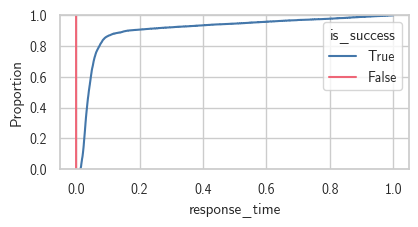

In [13]:
sns.ecdfplot(data=results_df, x='response_time', hue="is_success", hue_order=[True, False])

In [14]:
results_df.groupby('is_success')['response_time'].count()

is_success
False     7666
True     13542
Name: response_time, dtype: int64

In [15]:
# show orchestrator logs without switch events (that start with "switch_")
orchestrator_df[~orchestrator_df["log_type"].str.startswith("switch_")]

,time,log_type,sat,time_s
0,2024-07-05 13:03:16.731,deploy_start,1-685,0.000
1,2024-07-05 13:04:01.603,deploy_complete,1-685,44.872
32,2024-07-05 13:06:23.210,deploy_start,1-706,186.479
33,2024-07-05 13:07:07.702,deploy_complete,1-706,230.971
62,2024-07-05 13:07:07.824,undeploy_start,1-685,231.093
65,2024-07-05 13:07:09.293,undeploy_complete,1-685,232.562
66,2024-07-05 13:10:41.225,deploy_start,1-705,444.494
67,2024-07-05 13:10:59.194,deploy_complete,1-705,462.463
96,2024-07-05 13:10:59.302,undeploy_start,1-706,462.571
99,2024-07-05 13:11:00.785,undeploy_complete,1-706,464.054


In [16]:
# figure out the periods where two things where deployed at the same time
# iterate through the switch logs
period_logs = []
event_logs = []
for i, row in orchestrator_df.iterrows():
    if i < 3:
        continue
    if row["log_type"] == "deploy_start":
        period_logs.append([row["time_s"], None])
    if row["log_type"] == "undeploy_complete":
        period_logs[-1][1] = row["time_s"]
    if row["log_type"].startswith("switch_"):
        client = row["log_type"].split("_")[1]
        event_logs.append((row["time_s"], client))

period_logs

[[186.479, 232.562],
 [444.494, 464.054],
 [704.376, 750.94],
 [963.836, 1008.317],
 [1095.792, 1134.406],
 [1210.664, 1261.89],
 [1353.752, 1376.411]]

In [17]:
m = 0
for p in period_logs:
    m += p[1] - p[0]
    print(p[1] - p[0])
print(m/len(period_logs))
print(min(results_df["time_s"]), max(results_df["time_s"]))
print(max(results_df["time_s"]) - min(results_df["time_s"]))
print((m/len(period_logs))/(max(results_df["time_s"]) - min(results_df["time_s"])))

46.083
19.559999999999945
46.56400000000008
44.480999999999995
38.61400000000003
51.22600000000011
22.659000000000106
38.45528571428575
47.201059 1464.222032
1417.020973
0.02713812035743648


[(47.201059, 1464.222032), (0.0, 296.5352499999988)]

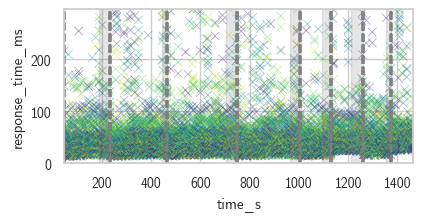

In [18]:
results_df["response_time_ms"] = results_df["response_time"] * 1000
g = sns.scatterplot(data=results_df[results_df["is_success"]], x='time_s', y='response_time_ms', alpha=0.5, marker="x", hue="client_no", legend=False, palette=sns.color_palette("viridis", len(results_df["client_no"].unique())))

for t in event_logs:
    plt.axvline(t[0], color="gray", linestyle="--")

for t in period_logs:
    plt.axvspan(t[0], t[1], alpha=0.2, color="gray")

put_95 = results_df["response_time_ms"].quantile(0.95)
start = min(results_df["time_s"])
end = max(results_df["time_s"])

g.set(xlim=(start, end), ylim=(0, put_95))

[(47.201059, 1464.222032), (0.0, 296.5352499999988)]

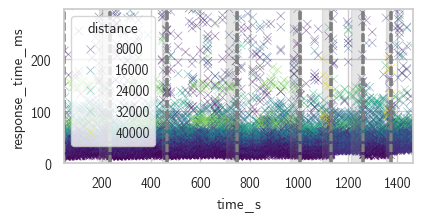

In [19]:
results_df["response_time_ms"] = results_df["response_time"] * 1000
g = sns.scatterplot(data=results_df[results_df["is_success"]], x='time_s', y='response_time_ms', alpha=0.5, marker="x", hue="distance", palette="viridis")

for t in event_logs:
    plt.axvline(t[0], color="gray", linestyle="--")

for t in period_logs:
    plt.axvspan(t[0], t[1], alpha=0.2, color="gray")

put_95 = results_df["response_time_ms"].quantile(0.95)
start = min(results_df["time_s"])
end = max(results_df["time_s"])

g.set(xlim=(start, end), ylim=(0, put_95))

/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_18253/2341686586.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_rolling["time"] = results_df_rolling["time_x"]


      host  level_1  response_time_ms                       time       time_s
0      572    16320          111.0010 2024-07-05 13:22:08.417099  1131.686099
1      572    16321          109.5095 2024-07-05 13:22:08.423948  1131.692948
2      572    16322          108.0180 2024-07-05 13:22:08.425417  1131.694417
3      572    16323          103.1765 2024-07-05 13:22:08.493134  1131.762134
4      572    16324           98.3350 2024-07-05 13:22:08.506466  1131.775466
...    ...      ...               ...                        ...          ...
12476  746    19971           41.3475 2024-07-05 13:26:11.257957  1374.526957
12477  746    19972           40.3455 2024-07-05 13:26:11.344698  1374.613698
12478  746    19973           39.5510 2024-07-05 13:26:11.358979  1374.627979
12479  746    19974           39.5510 2024-07-05 13:26:11.376594  1374.645594
12480  746    19975           40.3455 2024-07-05 13:26:11.441239  1374.710239

[12481 rows x 5 columns]


webf NOT subset; don't know how to subset; dropped


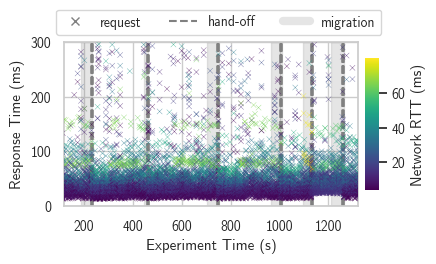

In [20]:
results_df["response_time_ms"] = results_df["response_time"] * 1000

put_95 = results_df["response_time_ms"].quantile(0.95)

graph_df = results_df[(results_df["is_success"]) & (results_df["response_time_ms"] < put_95)]

results_df_rolling = graph_df[["time_x", "response_time_ms", "host"]]
results_df_rolling["time"] = results_df_rolling["time_x"]
results_df_rolling = results_df_rolling.sort_values("time").groupby("host").rolling('10s', on="time").median(numeric_only=True).dropna().reset_index()
results_df_rolling["time_s"] = (results_df_rolling["time"] - start_time).astype(int) / 1e9
print(results_df_rolling)

cmap = sns.color_palette("viridis", as_cmap=True)

fig, ax = plt.subplots(figsize=(4.5, 2.5))
sns.scatterplot(data=graph_df, x='time_s', y='response_time_ms', alpha=0.7, marker="x", hue="distance", legend=False, palette=cmap, s=15, zorder=10, ax=ax)

# sns.lineplot(data=results_df_rolling, x='time_s', y='response_time_ms', ax=ax, zorder=12, color="black", linewidth=1.5)


for t in event_logs:
    # only really need this for one client
    if not t[1] == "46404":
        ax.axvline(t[0], color="gray", linestyle="--")
    # plt.axvline(t[0], color="gray", linestyle="--")


for t in period_logs:
    ax.axvspan(t[0], t[1], alpha=0.2, color="gray")

start = min(results_df["time_s"])
end = max(results_df["time_s"])

handles, labels = ax.get_legend_handles_labels()
labels.append("request")
# labels.append("10s median")
labels.append("hand-off")
labels.append("migration")
handles.append(plt.Line2D([0], [0], marker="x", color='gray', linestyle="None"))
# handles.append(plt.Line2D([0], [0], linestyle='-', color="black"))
handles.append(plt.Line2D([0], [0], linestyle='--', color='gray'))
handles.append(plt.Line2D([0], [0], linestyle='-', color='gray', alpha=0.2, linewidth=6))

fig.legend(handles=handles, labels=labels, title=None, loc="upper center", ncols=3, bbox_to_anchor=(0.5, 1.07))

ax.set(xlim=(120, 1320), ylim=(0, 300), ylabel="Response Time (ms)", xlabel="Experiment Time (s)")

norm = plt.Normalize(max(graph_df["distance"])/1e3*2, min(graph_df["distance"])/1e3*2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = ax.axes.figure.colorbar(sm, location='right', shrink=0.8, pad=0, aspect=10, anchor=(0.2, 0.5), ax=ax)
# cbar.ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%dms'))
cbar.set_label("Network RTT (ms)")
cbar.ax.yaxis.set_ticks([20, 40, 60])
cbar.outline.set_visible(False)

fig.tight_layout()
fig.savefig("iot-results.pdf", bbox_inches="tight")

/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_18253/2860257513.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


[Text(0, 0, '685'),
 Text(1, 0, '706'),
 Text(2, 0, '705'),
 Text(3, 0, '704'),
 Text(4, 0, '725'),
 Text(5, 0, '572'),
 Text(6, 0, '746'),
 Text(7, 0, '593')]

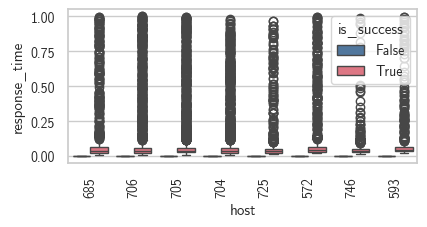

In [21]:
g = sns.boxplot(data=results_df, y='response_time', x='host', hue='is_success')
# make x axis labels vertical
g.set_xticklabels(g.get_xticklabels(), rotation=90)

<Axes: xlabel='time_s', ylabel='host'>

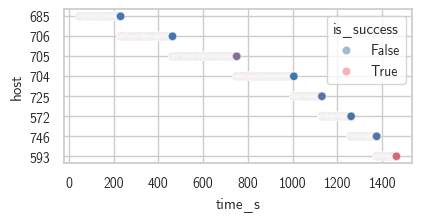

In [22]:
sns.scatterplot(data=results_df, x='time_s', y='host', hue='is_success', alpha=0.5)